# Identifying Customer Segments

## Project

There is a company in Germany which performs mail-order sales. It wants to target a marketing campaign to people that are most likely to purchase their products. It asks for help in identifying these groups of people. The goal of this project is to help the company by finding its customer segments.

The company is real and it is a real business case provided by the Bertlesmann Arvato Analytics. This is why the enterprise name is not revealed. Arvato provided real datasets with business data concerning the company's customers. They are not publicly accessible so I can only present here the results of my analysis.

### Project outline

This project is quite complicated, so here is the outline of what I am going to do.
1. Data pre-processing

    The dataset needs a fair amount of preprocessing. There are missing data, features that need re-encoding.


2. Feature transformation

    There is a lot of features, so I will apply PCA to reduce it. Before applying PCA features need to be scaled.


3. Clustering

    First, I am going to find clusters in general population. Then I will apply the same clustering to the customer population. I want to find clusters that are over-represented among consumers. This will indicate the company's customer profile.

## Import resources

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load the data

Arvato Analytics provided 4 files for the project:
- `AZDIAS_Subset.csv` - general German population data, 891211 persons x 85 features,
- `CUSTOMERS_Subset.csv` - company's customer population data, 191652 persons x 85 features,
- `Data_Dictionary.md` - file with information about the features in the provided datasets,
- `AZDIAS_Feature_Summary.csv` - attributes of each feature, 85 features x 4 columns.

Let's explore the data. General population and customer datasets have the same structure, so it will be enough to look at only one of them.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Display a first few rows
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Features seem to be encoded numerically, there are some `NaN` values.

In [4]:
# Print a few info records about the features to see how it looks
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


Here are the codes for missing data. It looks like some of missing values were encoded with the values given here.

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

You can see that many columns contain missing data. Notice that 4 of them have the type `object`. It indicates that these columns are not numerical.

## Step 1: Preprocessing

### Step 1.1: Assess missing data

There are obvious missing values that are coded as `NaN` but as you had a chance to notice, there are also missing values that are encoded with a special value.

#### Step 1.1.1: Convert missing value codes to NaNs

Let's use the fourth column of `feat_info` to identify the codes for missing value for each column. What I want to do with it is to convert all these values to NaNs. This will make working with missing values much simpler.

In [6]:
# Display all possible entries in the missing_or_unknow column
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

You can see that the code for missing data can be not only an int, but it also can be a string like 'X'.

I notice even more. The column `missing_or_unknown` is coded as a string, but its values are actually arrays of integers. To be useful, they need to be parsed into what they are, arrays of integers (except values like 'X' that are really a string).

Let's write a function that will parse these values.

In [7]:
# Helper function that tells if a string contains a digit
def contains_integer(str_val):
    return str_val.replace('-', '').isdigit()

# Convert value of type '[-1,X]' into array like [-1, 'X'] and return it
def get_missing_codes_array(str_val):
    content = str_val.replace('[', '').replace(']', '')
    if content == '':
        array = [] # Default value for str_val representing empty list
    else:
        array = content.split(',') # Produce array
    # Convert any number into int
    for i in range(len(array)):
        if contains_integer(array[i]):
            array[i] = int(array[i])
    return array

Now I can do the actual conversion. I will write it as a function so I can use it later for the customer set.

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
def convert_missing_codes_to_NaNs(dataset):
    for n in range(len(dataset.columns)):
        missing_str_value = feat_info['missing_or_unknown'][n]
        missing_codes_array = get_missing_codes_array(missing_str_value)
        dataset.iloc[:, n] = dataset.iloc[:, n].apply(lambda x: np.nan if x in missing_codes_array else x)
    
# Do the conversion for general dataset
convert_missing_codes_to_NaNs(azdias)

#### Step 1.1.2: Assess missing data in each column

Let's consider the number of missing data in each column and look for outliers and patterns.

In [9]:
# Count proportion of missing values for each column
def get_missing_column_counts(dataset):
    missing = dataset.isna().sum()
    missing = round(missing / len(dataset), 4)
    return missing

# Asses how much missing data there is in each column of the dataset
get_missing_column_counts(azdias)

AGER_TYP                0.7696
ALTERSKATEGORIE_GROB    0.0032
ANREDE_KZ               0.0000
CJT_GESAMTTYP           0.0054
FINANZ_MINIMALIST       0.0000
                         ...  
PLZ8_HHZ                0.1307
PLZ8_GBZ                0.1307
ARBEIT                  0.1093
ORTSGR_KLS9             0.1091
RELAT_AB                0.1093
Length: 85, dtype: float64

Here you can see that if a variable contains missing values, there are a few variables that share the same number of missing values. It means that these groups of variables are associated with each other in some way, because they must be sharing the reason for the missing values.

For example, variables starting with *PLZ8_* contain data about a wide neighborhood of a customer. So if for some reason the data about wide negihborhood couldn't be collected, there will be missing data among all variables describing the wide neighborhood.

(array([4.59927355, 4.71720364, 0.        , 0.11793009, 0.11793009,
        0.11793009, 0.11793009, 0.11793009, 0.        , 0.11793009]),
 array([0.     , 0.09976, 0.19952, 0.29928, 0.39904, 0.4988 , 0.59856,
        0.69832, 0.79808, 0.89784, 0.9976 ]),
 <a list of 10 Patch objects>)

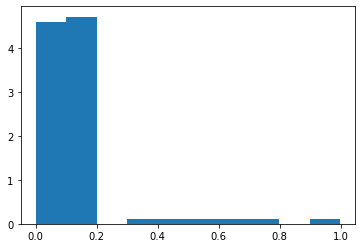

In [10]:
# Plot a histogram with number of features on y-axis, proportion of missing values on x-axis
plt.hist(get_missing_column_counts(azdias), density = True)

From the histogram I can see that the vast majority of features have at most 20% missing values. So I can say that any feature that has more than 20% missing values is an outlier.

Let's identify them.

In [11]:
# Identify outlier features
def get_outlier_features(dataset, threshold = 0.2):
    missing = get_missing_column_counts(dataset)
    return missing.loc[missing > threshold]

# Print the list of outlier features
print(get_outlier_features(azdias))

AGER_TYP        0.7696
GEBURTSJAHR     0.4402
TITEL_KZ        0.9976
ALTER_HH        0.3481
KK_KUNDENTYP    0.6560
KBA05_BAUMAX    0.5347
dtype: float64


You can see that there are 6 outlier features that contain more than 20% missing values. I am going to drop them for further anaylsis.

I want to keep the outliers in a variable, so I can remove them later from the consumer dataset.

In [12]:
# Store outlier features in a variable
outlier_features = get_outlier_features(azdias)

# Drop outlier features from the dataset
def drop_outlier_features(dataset):
    dataset.drop(outlier_features.index, axis = 1, inplace = True)

# Actual drop
drop_outlier_features(azdias)

#### Step 1.1.3: Assess missing data in each row

Now I'm going to perform a similar assessment for the rows of the dataset.

But this time the outliers are observations, not the features that you can simply drop and forget. They actually form a population of outliers and it needs evaluation. If the distribution of the other features is the same between the regular subset and the outlier subset, then they can be dropped. But if you notice that other features are distributed differently in this group, then it means that they form a distinct population that should be analyzed separately.

Let's see how missing data is distributed among observations.

In [13]:
# Count proportion of missing features in each row
def get_missing_row_counts(dataset):
    return dataset.isnull().sum(axis = 1)

# See the result
get_missing_row_counts(azdias)

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

Here I count the number of missing features for each row. Let's see it on the plot.

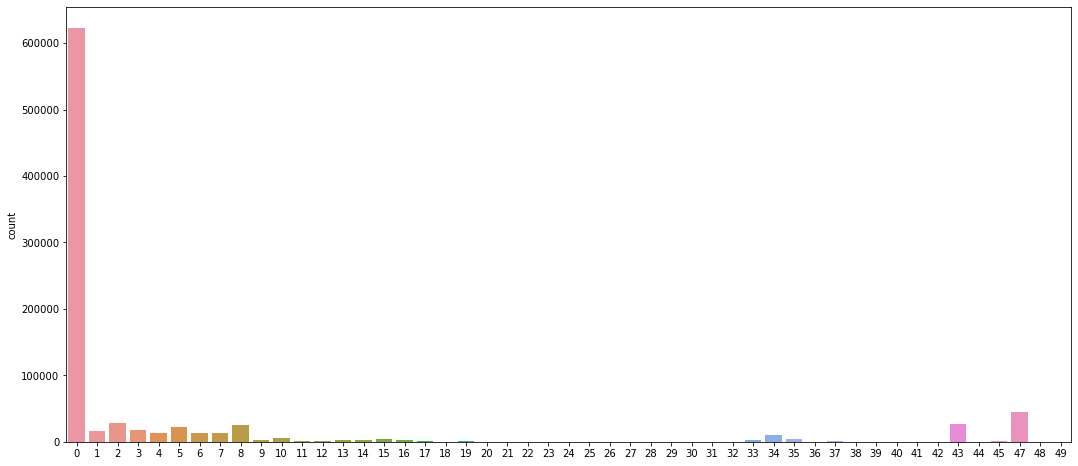

In [14]:
# Draw a histogram of number of missing features vs number of rows
plt.figure(figsize = (18, 8))
sns.countplot(get_missing_row_counts(azdias))

On the histogram you can see that the majority of rows have at most 8 missing features. I will consider any row with more than 8 values as an outlier.

Let's see how many of them is there.

In [15]:
# Identify outliers
def get_outlier_rows(dataset, threshold = 8):
    missing = get_missing_row_counts(dataset)
    return missing[missing > threshold]
    
# Count the number of them
get_outlier_rows(azdias)

0         43
11        47
14        47
17        47
20        10
          ..
891173    19
891175    47
891185    47
891187    47
891203    14
Length: 119520, dtype: int64

Based on the threshold, 119 520 outlier rows have been identified.

In [16]:
# Split the dataset into outlier and regular rows
def split_dataset_by_missing(dataset):
    outlier_rows = dataset.iloc[get_outlier_rows(dataset)]
    outlier_rows.index = get_outlier_rows(dataset).index
    regular_rows = dataset.drop(get_outlier_rows(dataset).index)
    return (regular_rows, outlier_rows)

# Do the actual split
regular_set, outlier_set = split_dataset_by_missing(azdias)

In [17]:
# Test the split
print('{} + {} == {}'.format(len(regular_set), len(outlier_set), len(azdias)))
print('Is number of regular and outlier rows equal to that of general datset? {}'.format(
      len(regular_set) + len(outlier_set) == len(azdias)
    )
)

771701 + 119520 == 891221
Is number of regular and outlier rows equal to that of general datset? True


Dataset is now correctly splitted into outlier observations and regular observations. It is the time for test. 

I want to asses whether these sets are different or not. I'm going to do this by comparing distribution of values between them. I will take a sample of five non-outlier features.

/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


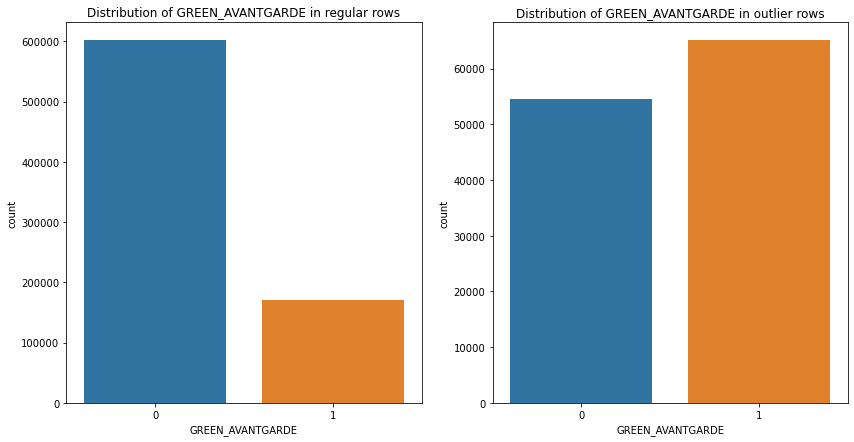

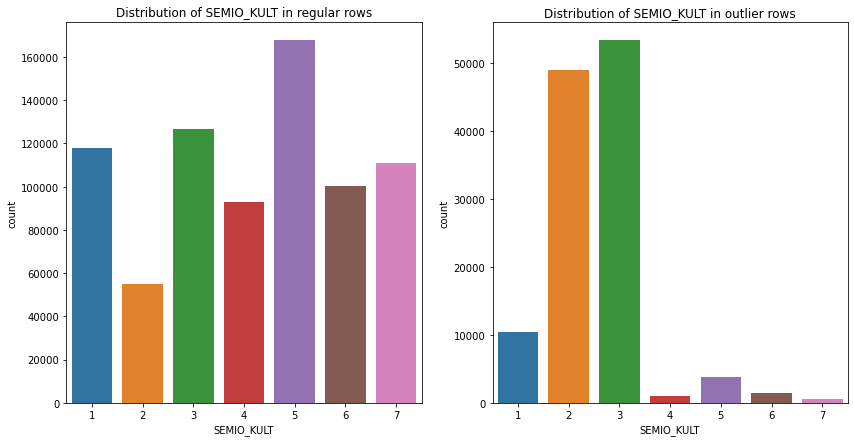

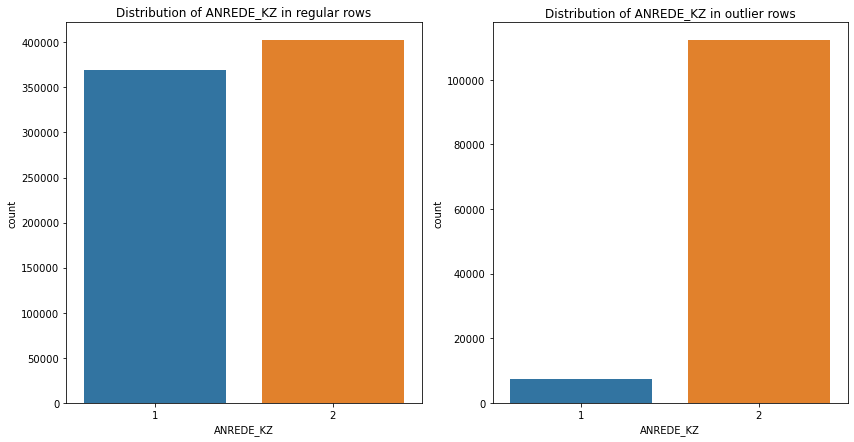

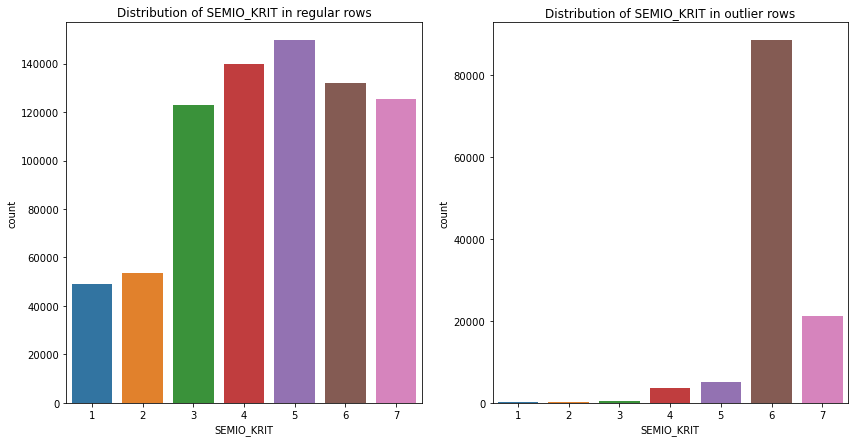

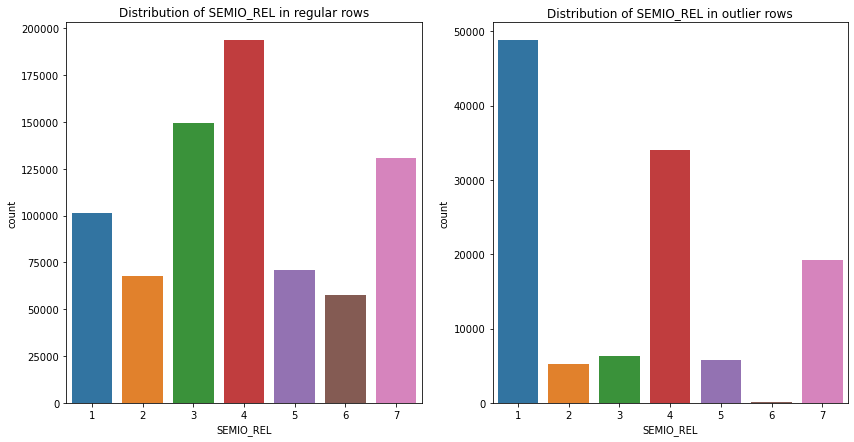

In [18]:
# Names of sample columns with no missing data
missing = get_missing_column_counts(azdias)
no_missing_column_names = [missing.index[i] for i in range(len(missing)) if missing[i] == 0]
sample_5_column_names = pd.Series(no_missing_column_names).sample(5, random_state = 42)

# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for column_name in sample_5_column_names:
    fig, ax = plt.subplots(figsize = (14, 7), ncols = 2)
    ax1 = sns.countplot(regular_set[column_name], ax = ax[0])
    ax1.set_title('Distribution of {} in regular rows'.format(column_name))
    ax2 = sns.countplot(outlier_set[column_name], ax = ax[1])
    ax2.set_title('Distribution of {} in outlier rows'.format(column_name))

    fig.show()

You can see that the distribution of features looks different between the plots on the left side and the right side. If the distributions were similar, you would expect that bars would have the similar shape on both of them.

Based on the plots I can say that outliers are a distinct group and I will get back to them later on in the analysis. For now, I will remove them from the dataset.

In [19]:
azdias.drop(outlier_set.index, inplace = True)

### Step 1.2: Select and Re-Encode Features

Algorithms work with numerical data and features that are not encoded numerically will need to be re-encoded. Let's take a look at the kinds of variables in the dataset:

- numeric features

    They need no action and can stay the way they are.


- ordinal features

    They are numeric but ordinal indicates that they are evenly spaced (not continous). It means that if a variable is of type 1 - 10, where 1 means 'completely disagree' and 10 means 'completely agree', value of 6.43 has no interpretation. However, you can always approximate 6.43 to 6 and say that it means 'slightly agree'. I'm going to make this simplifying assumption and treat them as numeric.


- categorical features

    They can be one-hot encoded (converted into a set of binary variables, each one for each category).


- mixed features

    They are of special kind. They can contain information about two or more features. You can re-encode them into a few separate variables if necessary.
    

Let's see how many variables of each kind are there. 

I'm going to take a look at only non-outlier features since I have removed them from the dataset already. At this point it makes sense to create a copy of `feat_info` that will include information only about non-outlier features. I will name it `reduced_feat_info` and will use it from now on.

ordinal 49
categorical 18
mixed 6
numeric 6


(array([49.,  0.,  0., 18.,  0.,  0.,  6.,  0.,  0.,  6.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

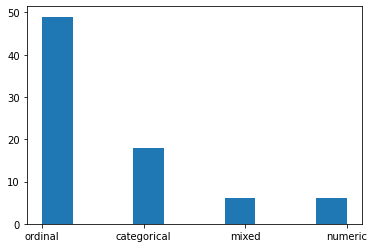

In [20]:
# Store a copy of reduced feat_info
reduced_feat_info = feat_info.copy()
for attribute in outlier_features.index:
    reduced_feat_info = reduced_feat_info.loc[reduced_feat_info['attribute'] != attribute]

# How many features are there of each data type?
for x in reduced_feat_info['type'].unique():
    print(x, sum(reduced_feat_info['type'] == x)) 

plt.hist(reduced_feat_info['type'])

There are 18 categorical features that may need one-hot encoding and 6 mixed features that need further anaylsis.

#### Step 1.2.1: Re-Encode Categorical Features

Categorical variables can be one of two types, binary or multi-level. Multi-level categorical variables need re-encoding. Binary variables need re-encoding only if they are not already encoded numerically.

I'm going to take a closer look at them now.

In [21]:
# Extract categorical variables
categorical_variable_names = reduced_feat_info.loc[reduced_feat_info['type'] == 'categorical']['attribute'].values

# Split them into binary and multi-level
binary = pd.DataFrame(columns = list(['column_name', 'is_string']))
multi_level = []

for column_name in categorical_variable_names:
    unique_values = azdias[column_name].unique()
    n_unique_values = len(unique_values)
    
    # correct for NaN
    if (any(pd.isnull(unique_values))):
        n_unique_values -= 1

    if (n_unique_values == 2):
        is_string = any([isinstance(x, str) for x in unique_values])
        binary = binary.append({'column_name' : column_name, 'is_string' : is_string}, ignore_index = True)
    else:
        multi_level.append(column_name)

# Print the results
print("Binary variables:")
print(binary)
print("\nNumber of multi-level variables:", len(multi_level))

Binary variables:
        column_name is_string
0         ANREDE_KZ     False
1  GREEN_AVANTGARDE     False
2           SOHO_KZ     False
3          VERS_TYP     False
4       OST_WEST_KZ      True

Number of multi-level variables: 13


There is a one binary variable that needs re-encoding, *OST_WEST_KZ*.

Fragment from data dictionary:
```
### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)
```

I'm going to encode it this way: 0 for the east and 1 for the west.

In [22]:
# Reassuring about its values
print(azdias['OST_WEST_KZ'].unique())

['W' 'O']


Except for `NaN` values, it looks like not only `W` needs re-encoding. As you can see `0` is a string too and I'm going to encode it as a number as well.

In [23]:
# Re-encode OST_WEST_KZ
def re_encode_ost_west_kz(dataset):
    dataset['OST_WEST_KZ'].replace({'W': 1, 'O' : 0}, inplace = True)
    
re_encode_ost_west_kz(azdias)

Binary variables are ready. Now I only need to apply one-hot encoding for multi-level ones.

One-hot encoder assumes that data contains no missing values, so I will impute the missings first, with the most frequent value.

In [24]:
# One-hot encode given variables, impute them first
def one_hot_encode(dataset, variables):
    # Impute variables with mode first
    for class_name in variables:
       dataset[class_name].fillna(dataset[class_name].value_counts().index[0], inplace = True)
    # Re-encode variables using hot-one encoding
    re_encoded = pd.get_dummies(dataset, columns = variables)
    return re_encoded

azdias = one_hot_encode(azdias, multi_level)
print("Total number of variables:", len(azdias.columns))

Total number of variables: 194


You can see that on-hot encoding created many new variables in place of the orignal ones.

#### Step 1.2.2: Engineer Mixed-Type Features

Now I'm going to look at the mixed type features and engineer new variables to replace them if needed.

In [25]:
# Extract mixed variables
mixed = reduced_feat_info.loc[reduced_feat_info['type'] == 'mixed']['attribute'].values
print("Mixed type variables:")
for var in mixed:
    print("-", var)

Mixed type variables:
- LP_LEBENSPHASE_FEIN
- LP_LEBENSPHASE_GROB
- PRAEGENDE_JUGENDJAHRE
- WOHNLAGE
- CAMEO_INTL_2015
- PLZ8_BAUMAX


##### Step 1.2.2.1: Engineer *LP_LEBENSPHASE_FEIN* and *LP_LEBENSPHASE_GROB*

*LP_LEBENSPHASE_FEIN* and *LP_LEBENSPHASE_GROB* contain the same type of information. They measure life stage as a mix of two features - family state and the level of earnings. The difference is in the level of detail. The first one is more detailed and has about 40 different levels, while the latter is more concise and contains 12 levels.

If I were to re-engineer them, I would split the information into two variables - family status and earning status. There are such variables in the dataset already. These are LP_FAMILIE_FEIN and LP_STATUS_GROB. Having this in mind, I will drop *LP_LEBENSPHASE_FEIN* and *LP_LEBENSPHASE_GROB* as redundant.

In [26]:
# Drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB from the dataset
def drop_lebensphase(dataset):
    dataset.drop('LP_LEBENSPHASE_FEIN', axis = 1, inplace = True)
    dataset.drop('LP_LEBENSPHASE_GROB', axis = 1, inplace = True)

drop_lebensphase(azdias)

##### Step 1.2.2.2: Engineer *PRAEGENDE_JUGENDJAHRE*

Let's investigate the next one, *PRAEGENDE_JUGENDJAHRE*. This variable contains information about *Dominating movement of person's youth* which can be split into three variables, *generation*, *movement* and *nation*. Here are code values that I'm going to use.

Dictionary for *generation*:
```
-  1: 40s - war years
-  2: 40s - reconstruction years
-  3: 50s - economic miracle
-  4: 50s - milk bar / Individualisation
-  5: 60s - economic miracle
-  6: 60s - generation 68 / student protestors
-  7: 60s - opponents to the building of the Wall
-  8: 70s - family orientation
-  9: 70s - peace movement
- 10: 80s - Generation Golf
- 11: 80s - ecological awareness
- 12: 80s - FDJ / communist party youth organisation
- 13: 80s - Swords into ploughshares
- 14: 90s - digital media kids
- 15: 90s - ecological awareness
```
Dictionary for *movement*:
```
- 0: Avantgarde
- 1: Mainstream
```
Dictionary for *nation*:
```
- 0: East
- 1: West
- 2: East+West
```

In [27]:
# Enigneer new variables for PRAEGENDE_JUGENDJAHRE
p_j_codes = {
    1 : [ 1, 1, 2 ],
    2 : [ 2, 0, 2 ],
    3 : [ 3, 0, 2 ],
    4 : [ 4, 0, 2 ],
    5 : [ 5, 1, 2 ],
    6 : [ 6, 0, 1 ],
    7 : [ 7, 0, 0 ],
    8 : [ 8, 1, 2 ],
    9 : [ 9, 0, 2 ],
    10 : [ 10, 1, 1 ],
    11 : [ 11, 0, 1 ],
    12 : [ 12, 1, 0 ],
    13 : [ 13, 0, 0 ],
    14 : [ 14, 1, 2 ],
    15 : [ 15, 0, 2]
}

generation = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: p_j_codes.get(x)[0] if not pd.isnull(x) else x)
movement = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: p_j_codes.get(x)[1] if not pd.isnull(x) else x)
nation = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: p_j_codes.get(x)[2] if not pd.isnull(x) else x)

Let's examine the 3 new variables.

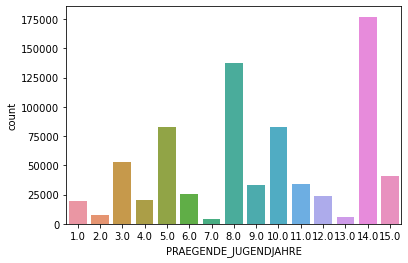

In [28]:
sns.countplot(generation)

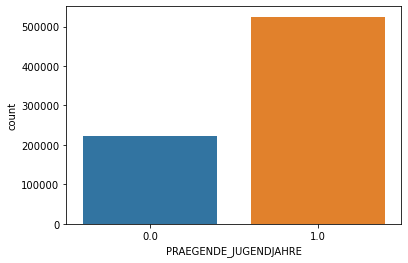

In [29]:
sns.countplot(movement)

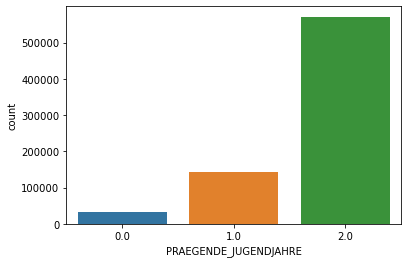

In [30]:
sns.countplot(nation)

Out of three new variables, *nation* doesn't seem to be very informative as most of the people belong to *EW* nation. I will drop it.

Now I can write a function for this for future use and apply the changes to the dataset.

In [31]:
# Enigneer new variables for PRAEGENDE_JUGENDJAHRE in the dataset
def re_engineer_pj(dataset):    
    p_j_codes = {
        1 : [ 1, 1 ],
        2 : [ 2, 0 ],
        3 : [ 3, 0 ],
        4 : [ 4, 0 ],
        5 : [ 5, 1 ],
        6 : [ 6, 0 ],
        7 : [ 7, 0 ],
        8 : [ 8, 1 ],
        9 : [ 9, 0 ],
        10 : [ 10, 1 ],
        11 : [ 11, 0 ],
        12 : [ 12, 1 ],
        13 : [ 13, 0 ],
        14 : [ 14, 1 ],
        15 : [ 15, 0 ]
    }
    
    generation = dataset['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: p_j_codes.get(x)[0] if not pd.isnull(x) else x)
    movement = dataset['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: p_j_codes.get(x)[1] if not pd.isnull(x) else x)

    dataset.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    dataset.insert(len(dataset.columns), 'generation', generation)
    dataset.insert(len(dataset.columns), 'movement', movement)
    
    return dataset

re_engineer_pj(azdias)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,movement
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,0,14.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,15.0,0.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,8.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,8.0,1.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,1,0,0,0,0,0,0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0,0,0,0,0,0,0,0,14.0,1.0
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,0,0,0,0,0,0,1,0,10.0,1.0
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,0,0,0,0,0,0,0,0,14.0,1.0
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,0,0,0,0,0,0,1,0,14.0,1.0


##### Step 1.2.2.3: Engineer *WOHNLAGE*

Now is the time for next variable, *WOHNLAGE*. It contains information about the quality of neigborhood or information that it is a building in new or old rural neighborhood. I'm going to split it into two variables in the following way.

Dictionary for *negihborhood_quality*:
```
- 0: no score calculated
- 1: very good neighborhood
- 2: good neighborhood
- 3: average neighborhood
- 4: poor neighborhood
- 5: very poor neighborhood
```

Dictionary for *rural_neighborhood*:
```
- 0: no score calculated
- 1: rural neighborhood
- 2: new building in rural neighborhood
```

In [32]:
# Engineer new variables for WOHNLAGE
wohnlage_codes = {
    0 : [ 0, 0 ],
    1 : [ 1, 0 ],
    2 : [ 2, 0 ],
    3 : [ 3, 0 ],
    4 : [ 4, 0 ],
    5 : [ 5, 0 ],
    7 : [ 0, 1 ],
    8 : [ 0, 2 ],
}

neighborhood_quality = azdias['WOHNLAGE'].apply(
    lambda x: wohnlage_codes.get(x)[0] if not pd.isnull(x) else x
)
rural_neighborhood = azdias['WOHNLAGE'].apply(
    lambda x: wohnlage_codes.get(x)[1] if not pd.isnull(x) else x
)

Now that I have engineered two new variables, let's see their distributions.

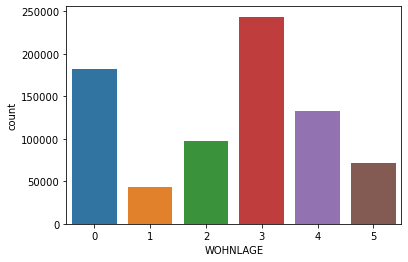

In [33]:
# Investigate new variables
sns.countplot(neighborhood_quality)

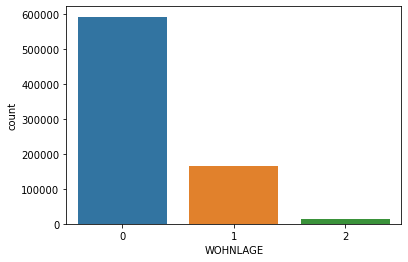

In [34]:
sns.countplot(rural_neighborhood)

You can see that the value 2 for *rural_neighborhood* is very rare. I'm going to change its coding and make it a binary variable, so the categories 1 and 2 will be merged together.

Dictionary for *rural_neighborhood*:
```
-  0: no score calculated
-  1: rural neighborhood
```

Let's write a function for this and apply the changes to the dataset.

In [35]:
# Engineer new variables for WOHNLAGE in the dataset
def re_engineer_wohnlage(dataset):
    wohnlage_codes = {
        0 : [ 0, 0 ],
        1 : [ 1, 0 ],
        2 : [ 2, 0 ],
        3 : [ 3, 0 ],
        4 : [ 4, 0 ],
        5 : [ 5, 0 ],
        7 : [ 0, 1 ],
        8 : [ 0, 1 ],
    }

    neighborhood_quality = dataset['WOHNLAGE'].apply(
        lambda x: wohnlage_codes.get(x)[0] if not pd.isnull(x) else x
    )
    rural_neighborhood = dataset['WOHNLAGE'].apply(
        lambda x: wohnlage_codes.get(x)[1] if not pd.isnull(x) else x
    )
    
    dataset.drop('WOHNLAGE', axis = 1, inplace = True)
    dataset.insert(len(dataset.columns), 'neighborhood_quality', neighborhood_quality)
    dataset.insert(len(dataset.columns), 'rural_neighborhood', rural_neighborhood)
    
re_engineer_wohnlage(azdias)

##### Step 1.2.2.4: Engineer *CAMEO_INTL_2015*

Now I will look at *CAMEO_INTL_2015*. It contains information about household wealth and family stage. I am going to create two new variables in place of it.

Dictionary for *household_wealth*:
```
- 1: Wealthy Households
- 2: Prosperous Households
- 3: Comfortable Households
- 4: Less Affluent Households
- 5: Poorer Households
```
Dictionary for *family_stage*:
```
- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families &  Mature Couples
- 5: Elders In Retirement
```

In [36]:
# Enigneer new variables for CAMEO_INTL_2015
household_wealth = azdias['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if not pd.isnull(x) else x)
family_stage = azdias['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if not pd.isnull(x) else x)

Let's see the distributions of these new features.

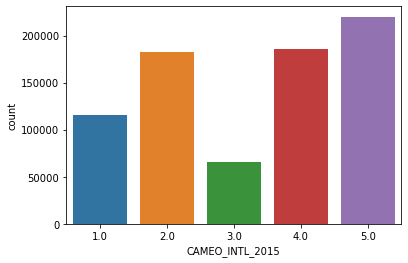

In [37]:
sns.countplot(household_wealth)

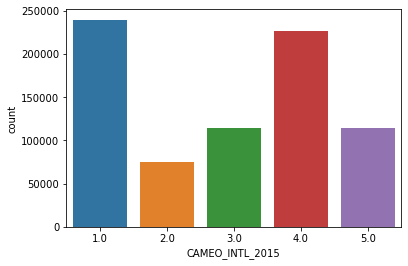

In [38]:
sns.countplot(family_stage)

Both features look good and diffrentiating and I'm going to apply the changes to the data.

In [39]:
# Enigneer new variables for CAMEO_INTL_2015 in the dataset
def re_engineer_cameo(dataset):
    household_wealth = dataset['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if not pd.isnull(x) else x)
    family_stage = dataset['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if not pd.isnull(x) else x)

    dataset.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
    dataset.insert(len(dataset.columns), 'household_wealth', household_wealth)
    dataset.insert(len(dataset.columns), 'family_stage', family_stage)

re_engineer_cameo(azdias)

##### Step 1.2.2.5: Engineer *PLZ8_BAUMAX*

The last feature, *PLZ8_BAUMAX* brings information about the most common building type within the wide neighborhod. It makes a distinction on houses and business buildings. I'm going to replace it with a new variable.

Dictionary for *plz8_houses*:
```
- 0: mainly not houses (business buildings)
- 1: mainly 1-2 family homes
- 2: mainly 3-5 family homes
- 3: mainly 6-10 family homes
- 4: mainly 10+ family homes
```

In [40]:
# Enigneer new variable for PLZ8_BAUMAX
plz8_houses = azdias['PLZ8_BAUMAX'].apply(lambda x: 0 if x == 5 else x)

Let's see its distribution.

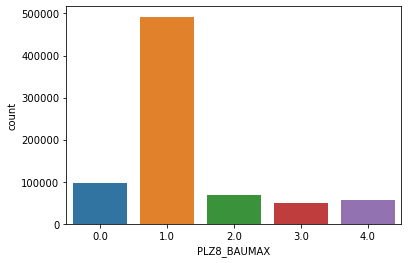

In [41]:
sns.countplot(plz8_houses)

As you can see, it is dominated by value 1. It doesn't look to be very informative, so I will drop the orignal variable from the dataset.

In [42]:
# Drop PLZ8_BAUMAX from the dataset
def drop_baumax(dataset):
    dataset.drop('PLZ8_BAUMAX', axis = 1, inplace = True)

drop_baumax(azdias)

### Step 1.3: Create a cleaning function

Here I'm going to create a cleaning function that I can use to clean the general or the customer dataset without re-running the previous cells again.

My intention is for both datasets to have the same structure. That's why I will remove exactly the same outlier features from both datasets. I will also use the same threshold for outlier rows and apply the same re-encoding of the variables.

In [43]:
def clean_data(input_dataset):
    dataset = input_dataset.copy()
    # Replace missing codes with NaNs
    convert_missing_codes_to_NaNs(dataset)
    # Drop outlier features
    drop_outlier_features(dataset)
    # Drop outlier rows
    dataset, outlier_rows = split_dataset_by_missing(dataset)

    # Re-encode categorical variables
    re_encode_ost_west_kz(dataset)
    dataset = one_hot_encode(dataset, multi_level)

    # Drop or re-engineer mixed type variables
    drop_lebensphase(dataset)
    re_engineer_pj(dataset)
    re_engineer_wohnlage(dataset)
    re_engineer_cameo(dataset)
    drop_baumax(dataset)
    
    return (dataset, outlier_rows)

Let's use the cleaning function and create a fresh copy of the dataset before the analysis.

In [44]:
general, general_outliers = clean_data(pd.read_csv('AZDIAS_Subset.csv', sep = ';'))